#Report: CSP and Probabilistic Reasoning for Minesweeper

Authors: Roomba Riders
- Alice Nicoletta 683017, a.nicoletta@studenti.unipi.it
- Gaetano Barresi 579102, g.barresi2@studenti.unipi.it
- Leonardo Cozzolino 615179, l.cozzolino3@studenti.unipi.it

Link to github repo: https://github.com/tanobar/minesweeper_prj.git

## Introduction

The goal of this project is to design and evaluate an intelligent agent capable of solving the game of Minesweeper using Constraint Satisfaction Problem (CSP) and Probabilistic Reasoning (PR) paradigms. Minesweeper is a puzzle game that combines elements of constraint satisfaction, probabilistic reasoning, and search. Due to its inherent uncertainty and combinatorial complexity, it serves as a valuable testbed for AI strategies.

This work implements and compares 4 different setups of agents:
- **Random Agent**
- **Backtracking agent: an agent that uses plain Backtracking algorithm**
- **Advanced agent: Backtracking + Minimum Remaining Values (MRV) with Degree Heuristic and Least Constraining Value (LCV)**
- **GAC3 agent: an Advanced agent that uses also Generalized Arc Consistency algorithm**

All the setups, but Random agent, use PR when inference is not enough.

The performance of the agents is assessed in terms of win rate, average number of revealed cells, average time per move/game.

## Related Works

The Minesweeper problem can be modeled as a CSP. In the literature [AIMA], common techniques include:

- Backtracking with heuristics (such as MRV, LCV, and Degree heuristic) to reduce the search space.

- Forward Checking and Arc Consistency, which help prune inconsistent assignments early, improving efficiency compared to plain backtracking.

However, Minesweeper inherently involves ambiguous situations where pure logical deduction is insufficient. In such cases, we propose the use of PR, estimating the likelihood that a given cell contains a mine and selecting the safest move accordingly.

This approach can be useful to determine whether the game grid can be deterministically solved (or at least inferred by strong hints) by a human, without the need for random guessing.

In summary, related works highlight a combination of deterministic CSP approaches and probabilistic methods, which provide the theoretical foundation for the agents developed in this project.

## Methodologies

### Problem formulation

To solve a minesweeper grid, it can be naturally translated into a CSP, since each value of a numeric cell represents a constraint involving its surrounding ones. <br>
Fixing some notation, we represent the cells of our grid with boolean variables $X_i\in D_i=\{0,1\}$,
$$X_i =
\begin{cases}
0 & \text{if it is safe}  \\
1 & \text{if it is a mine}.
\end{cases}
$$
The underlying graph of our CSP is obviously inherited from the grid structure: each variable partecipates in the constraints of its 8 neighbors
We can define a function that maps each of these variables to its numeric value (given they are not mines) $v:Vars→[0,8]$, and the neighborhood $N(X_i)$ of a variable $X_i$.

We simply define constraints like this:
$$
\forall i \quad v(X_i) = x_i \iff \sum_{X_j\in N(X_i)} X_j = x_i,
$$
or, if we want to pack the informations in a single object, as an ordered triple $c_i = (X_i, N(X_i), v(X_i))$.



### Recursively exploring neighbors of zero cells

This is the most trivial tactic to apply and something that the game does for you automatically, as their neighborhood is always safe.<br>
Whenever $v(X_i) = 0$, the agent immediately reveals any cell in $N(X_i)$. This is repeated until no more zero cells are found. Beyond this, the first fallback strategy awaits.

### Leveraging Generalized Arc Consistency (GAC3) as the main pruning strategy

Regarding the search strategies of our agent, the one that does most of the job (and does it fast) is the Generalized Arc Consistency. Since $\forall i \quad|D_i|=2$, GAC-3 needs to be prune a variable's domain just once to infer whether to reveal or flag it. <br>
Moreover, no domain can ever be pruned twice, as we know that the generated grid always admits a consistent assignment. <br>
The strategy is very similar the classic AC3, but extends the definition of arc consistency to variable-constraint pairs $\langle X,c\rangle$, where $c$ has scope $\{X, Y_1,\dots,Y_n\}$, with $\{Y_i\}_i$ being the variables involved in the constraint. <br>
See [[GAC3]](https://artint.info/3e/html/ArtInt3e.Ch4.S3.html) for more details. <br>
The interesting part for our problem is that we don't need exhaustive search or cumbersome tricks to ensure the consistency: since all of the domains are just made up of zeros and ones and our constraints are trivial sums between (at worst) 8 variables, we can simply check if the constraint required sum lies between the lower and upper bounds of the involved variables sums (lines 193-194 of `agent.py`):
```
lo = sum(min(self.Domains[v]) for v in others) #lower bound di need
hi = sum(max(self.Domains[v]) for v in others) #upper bound di need
```
Thus, GAC3 turns out be very convenient and cheap, as long as it is able to prune. Whenever domains stop changing, we move to the backtracking strategy, which is more "branchy", so inherently slower and of exponential nature.




### Backtracking

The backtracking search, on the other hand, is the most basic algorithm to solve CSPs: it simply assigns values to variables one by one and recursively explores the resulting partial assignments, backtracking whenever a constraint is violated. Although complete, this strategy is inherently exponential and quickly becomes impractical without heuristics.

To mitigate this, we incorporated three classic improvements. First, the MRV heuristic selects next the variable with the smallest domain, i.e. the one most constrained, in order to fail early if no consistent assignment exists. Second, the Degree heuristic breaks ties by choosing the variable that is involved in the largest number of constraints, so as to maximize its pruning power on the remaining search space. Finally, the LCV heuristic guides the assignment of values by preferring those that leave the most freedom to the other variables, reducing the risk of dead-ends later in the search. With these additions, the backtracking step becomes much more effective, complementing the inference power of GAC3 when pure propagation is no longer sufficient.

For computational limits, the maximum number of variables that can enter the backtracking algorithm has been bounded up to 35. Beyond this value (or when no safe assignments were found), the agent switches to probabilistic reasoning.

### Probabilistic Reasoning Module


When the logical solver (CSP/AC) cannot prove a certainly-safe move, this module **estimates a mine probability for each admissible unknown cell** and proposes the **minimum-risk** action. It never mutates the grid; it returns a risk map and one suggested move.


#### Frontier and Constraints

- Every revealed number states: “among my unknown neighbors there must be exactly *k minus already-known mines*.”
- Any unknown cell appearing in at least one such statement belongs to the **frontier**.
- Connect two unknown cells if they co-occur in at least one statement; this forms a **variable graph**. Its connected components are **independent** and are solved separately, then merged.

Splitting by shared constraints manages complexity, enables exact solutions for smaller components, and ensures a globally consistent result when reassembled.

#### Inference by Component

#### For small components
If a component has few variables (default `max_vars_exact = 22`), we **enumerate all assignments** that satisfy its local constraints and compute, for each cell, how often it is a mine among valid assignments (exact marginal).  
If the component is inconsistent (no valid assignment), we **do not fail**: we route it to the approximate path below.

#### For large components
We proceed in three steps:

1. **Global prior.**  
   Let $U$ be all admissible unknown cells (excluding flags). If the total number of mines is known, we use a base rate
   $$
   p_0 \approx \frac{M_{\text{rem}}}{|U|}\,,
   $$
   otherwise we adopt a neutral uniform default.

2. **Outside cells.**  
   Cells **not** in the frontier (i.e., not adjacent to any number) keep a consistent base rate. Intuitively: after accounting for what frontier cells “expect,” we **redistribute the remaining mine mass evenly** across true outside cells so they get a sane probability even with no local evidence. A simple consistent choice is
   $$
   p_{\text{out}} \approx \mathrm{clip}_{[0,1]}\!\left(\frac{\max(0,\,M_{\text{rem}}-E_F)}{\max(1,\,|U\setminus F|)}\right),
   $$
   where $E_F=\sum_{v\in F} p(v)$ is the expected mine mass on frontier cells.

3. **Frontier cells: local “pressure.”**  
   For each frontier cell $v$, inspect every numbered neighbor $s$: how many mines does $s$ still **need** and how many **unknowns** remain around $s$? The ratio “need ÷ unknowns” is a **pressure hint** from $s$ to $v$. Averaging hints over all relevant $s$ gives a local score $\mathrm{lp}(v)$.  
   We then **blend** the prior and this score:
   $$
   p(v) \;\leftarrow\; (1-\alpha)\,p(v) \;+\; \alpha\,\mathrm{lp}(v),
   \qquad \alpha\in(0,1)\ \text{(default }0.7\text{),}
   $$
   and clip to $[0,1]$. If a cell has no numbered neighbors, we keep its prior.

#### Soft Calibration

Cells solved **exactly** contribute a fixed mine mass; cells solved **approximately** are flexible.  
If the total flexible mass drifts from the **remaining mine budget** (after subtracting exact mass) beyond a small tolerance (~10%), we apply a **single multiplicative scaling** to all flexible probabilities (then re-clip). This preserves exact results while keeping the overall map consistent with the global mine count, without over-tuning any single cell.

#### Final Risk Map and Move Selection

Merging all components yields one risk map
$$
p:\; U \to [0,1].
$$
The proposed action is the admissible cell with **minimum** $p(v)$.  
On ties, we prefer the cell with **more adjacent unknowns** (simple proxy for expected information gain); if still tied, we use a **deterministic** fallback for reproducibility.

#### Assumptions and Edge Cases

- Constraints are built from the **8-neighborhood**; their targets are safely clamped to valid ranges.
- Components are considered **independent** after the frontier split.
- Inconsistencies at component level trigger the **approximate** path rather than an error.
- All probabilities are **kept in $[0,1]$** at every step.


### Last fallback strategy: random guess

Whenever probabilistic reasoning fails to pick a (probably) safe cell, as the current state might be completely ambiguous, the last resort is to sample randomly from the rest of the grid. This is a tactic often used by human players, as one can hope to find a zero and dig their way to reconnect to the previously explored cells.<br>
Of course, this is not really a strategy, there is no logic behind it and it's realistically prone to fail easily, but it remind us that most of minesweeper grids on high mine density can't be solved neither by pure logic, nor by smart guessing. <br>
An example of impossible-to-choose situation is the following:
\begin{array}{ccc}
X & ? & ? \\
X & 3 & 1 \\
2 & 1 & 0 \\
\end{array}
This case is impossible to solve deterministically and both the "?" cells are equally probable to be mines. <br>
However, the triggering of this strategy (or even the previous one) can help to easily classify grids as logically solvable or not and build a database for no-guessing mode.

### Implementation choices


The game loop revolves around interaction between the agent and the environment. <br>
The environment (`env: MinesweeperEnv`) object initially generates the grid (a list of lists) with uniformly distributed mines, based on the handed height (`n_row`), width (`n_col`) and the number of mines (`m`). `env`is responsable for the storage of the full grid and for revealing cells when queried by the agent. <br>
The agent (`agent: Agent`) has several attributes to store information about the current state, constraints, variables, past actions, safe cells and mines, and so on. Its methods wrap around the above mentioned techniques, but at the very high level, in the game loop, what it does is `choose_action`, `observe` (to update knowledge on safe cells) and `mark_mine`. <br>
The knowledge of the agent (`agent.knowledge`) is a list of lists, representing what the agents knows about the grid in the current state. At the beginning, it is initialised with $?$ symbols, . When updated, safe cells are represented by their numeric value, while flagged positions are marked with $X$. If the agent steps into a mine, the knowledge is updated with a $M$ in that position and the game interrupts.

To begin, the agent is handed a safe cell to start; priority is given to 0/1-valued cells, otherwise the grid is scanned for the first non-mine cell. <br>
At each iteration, the agent updates its knowledge, constraints and variables to choose a new action. Among the available actions, the agent can
*   reveal all safe cells (if any);   
*   flag all detected mines (if any);
*   reveal a cell, if the previous are not available. Here the cell is chosen either  by probabilist reasoning or by a uniform random sampling among unrevealed cells.

For any "reveal" action, the environment returns the numeric value (for safe cells) or, in case of a mine, the game terminates with a loss.

A GUI (`main.py` only feature) shows the current state of the agent knowledge of the grid, with flagged bombs depicted as red squares, safe cells with gray squares and their numeric value inside (none if the value is 0) and unknown cells as white squares; finally, a counter displays the remaining bombs to flag. These features are just to mimic the more familiar classic minesweeper desktop app on older operating systems. <br>
If the agent reveals a mine, the cell is displayed as black, before returning "game over" soon after.
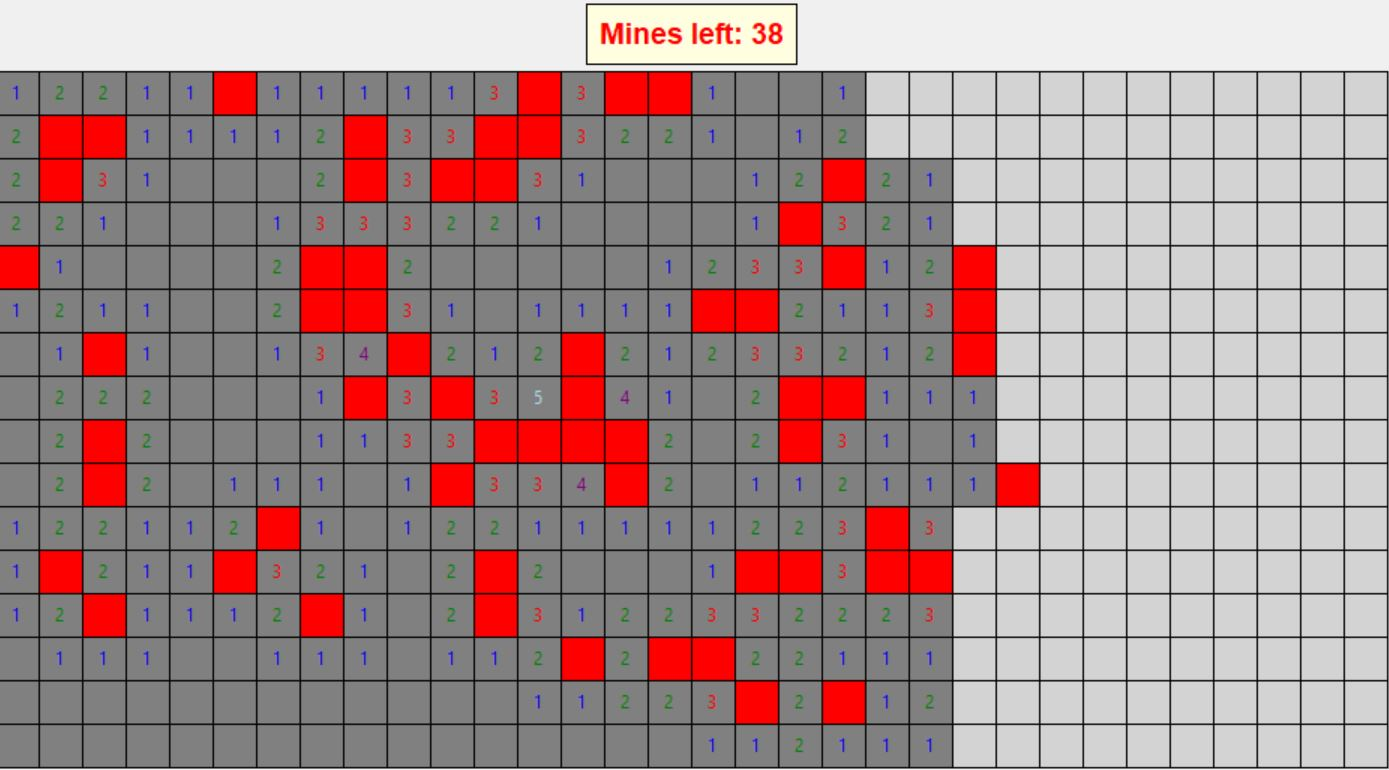




## Assessment


To evaluate the effectiveness of the different strategies implemented in the Minesweeper agent, a systematic assessment was conducted to test performance across game configurations of increasing difficulty. The goal was to objectively measure the capabilities of each strategy and to identify trade-offs between accuracy and computational speed.

### Choice of Metrics

Four key metrics were identified to evaluate agent performance:

1. **Win Rate**: The percentage of games successfully completed (all mines identified and all safe cells revealed). This is the primary metric indicating the effectiveness of a strategy.

2. **Average Number of Revealed Cells**: Measures how much of the grid the agent is able to explore before either failing or winning. A stronger strategy should reveal more cells before making mistakes.

3. **Average Time per Move**: The computational time required to calculate each individual action. This is important for assessing the feasibility of the strategy in real-time applications.

4. **Average Time per Game**: The total duration of a complete game. This combines the number of moves required with the computation speed for each move.

### Test Configurations

The assessment was structured into three progressive modes that gradually increase in complexity:

**Mode 1 - Small Grid (10x10, 15 mines, 15% density)**
- Objective: Comprehensive comparison of all four implemented strategies  
- Strategies tested: `random`, `backtracking`, `backtracking_advanced`, `backtracking_gac3`  
- Number of games: 100 per strategy  
- Purpose: Establish a baseline and identify the performance hierarchy  

**Mode 2 - Medium Grid (16x16, 51 mines, 20% density)**
- Objective: Evaluate the scalability of the most promising strategies  
- Strategies tested: `backtracking_advanced`, `backtracking_gac3`  
- Number of games: 100 per strategy  
- Purpose: Analyze behavior on problems of intermediate complexity  

**Mode 3 - Expert Grid (16x30, 99 mines)**
- Objective: Test the limits of the best-performing strategy  
- Strategy tested: `backtracking_gac3`  
- Number of games: 50 (reduced due to higher computational complexity)  
- Purpose: Assess performance in a maximum-difficulty scenario  


### Results

### Mode 1: Full Comparison (10x10 Grid)

The results of the first mode clearly outlined the hierarchy of the strategies:

| Strategy              | Win Rate | Avg. Revealed Cells | Avg. Time per Move | Avg. Time per Game | Observation |
|------------------------|----------|----------------------|---------------------|---------------------|-------------|
| **Backtracking Advanced** | 91%      | 81.2 ± 16.3          | 8.54 ± 9.55 ms      | 0.19 ± 0.24 s       | The most effective strategy overall, combining CSP with optimized heuristics and probabilistic reasoning as fallback. |
| **Basic Backtracking**    | 89%      | 84.1 ± 7.0           | 7.70 ± 26.93 ms     | 0.19 ± 0.68 s       | Excellent performance with simpler implementation. Demonstrates the strong foundation of the CSP approach. |
| **Backtracking GAC3**     | 88%      | 80.2 ± 18.4          | 1.74 ± 3.89 ms      | 0.04 ± 0.09 s       | Remarkably fast execution with competitive accuracy. GAC3 constraint propagation provides significant speed advantages. |
| **Random**                | 0%       | 42.8 ± 20.2          | 0.004 ± 0.044 ms    | 0.0002 ± 0.001 s    | Completely ineffective; serves as a baseline to demonstrate the importance of artificial intelligence in this problem. |

### Mode 2: Advanced Strategies (16x16 Grid)

The test on a medium grid revealed interesting scalability dynamics:

| Strategy               | Win Rate | Avg. Revealed Cells | Avg. Time per Move | Avg. Time per Game | Observation |
|-------------------------|----------|----------------------|---------------------|---------------------|-------------|
| **Backtracking GAC3**     | 59%      | 153.7 ± 81.2         | 31.65 ± 88.08 ms    | 1.44 ± 6.49 s       | Outperforms the Advanced strategy on complex grids, demonstrating the effectiveness of constraint propagation at scale. |
| **Backtracking Advanced** | 55%      | 159.7 ± 78.5         | 53.75 ± 57.51 ms    | 2.61 ± 3.05 s       | Lower performance and slower. Advanced heuristics struggle without systematic constraint propagation on larger grids. |

### Mode 3: Limit Test (Expert Grid 16x30)

The test on the expert grid evaluated the absolute limits of the best-performing strategy:

| Strategy            | Win Rate | Avg. Revealed Cells | Avg. Time per Move | Avg. Time per Game | Observation |
|----------------------|----------|----------------------|---------------------|---------------------|-------------|
| **Backtracking GAC3** | 46%      | 269.9 ± 163.7        | 30.72 ± 50.64 ms    | 2.65 ± 5.58 s       | Maintains excellent performance even in extreme scenarios. A 46% success rate on an expert grid demonstrates robustness and scalability. |


### Interpretation

The assessment results highlight several key patterns in the behavior of the tested strategies. First, there is a clear degradation of performance as grid complexity increases. The win rate drops predictably when moving from small to medium and finally to expert grids: from around 88–91% for the best strategies in the first mode, to 55–59% in the second, and down to 46% in the expert setting. This trend was expected and reflects the intrinsically hard nature of Minesweeper on larger boards, where the combinatorial explosion of possibilities makes inference increasingly difficult, thus triggering the artificial limit of 35 variables for backtracking.

Due to slight variance in the grids generation, the results differ across the methods, but not significantly. This confirms that the logic (at this size) is not influenced by the strategies, as their purpose is to prune early for the backtracking algorithm. <br>
More interestingly, GAC3 demonstrates superior computational efficiency: it is nearly 5x faster on small grids (1.74ms vs 8.54ms per move) and maintains this speed advantage even on complex grids (31.65ms vs 53.75ms).

The role of constraint propagation becomes crucial at scale. GAC3's systematic domain pruning approach not only scales better in terms of win rate but maintains remarkably consistent performance characteristics across different grid sizes. The strategy achieves excellent time stability, representing efficient algorithmic scaling. In contrast, Advanced strategy suffers from the computational burden of evaluating complex heuristics without the benefit of systematic constraint reduction, leading to both lower win rates and slower execution on larger problems.




### Tests for the Probabilistic Reasoning Module

This test suite validates the module that assigns each unknown cell a probability of containing a mine and selects the **minimum-risk** move. The scenarios cover global prior, local pressure and blending, calibration to the remaining-mines “budget,” agreement with **exact enumeration** on micro frontiers, the **monotonicity** property under new evidence, handling of **outside** cells, informative tie-breaks under symmetry, and robustness under inconsistent constraints. Results are checked against expected values (with numerical tolerances) and against deterministic choices when risks are tied.

---

#### Test 1 — Uniform prior with no frontier


\begin{array}{ccc}
? & ? & ? \\
? & ? & ? \\
? & ? & ? \\
\end{array}

On a $3\times 3$ grid entirely unknown with a prior of 3 mines, the lack of constraints enforces a uniform distribution: every “?” gets $p_0=3/9=0.333$. The algorithm proposes a valid cell (e.g., $(1,1)$), confirming that with no local information the estimate matches the global prior.

#### Test 2 — Local pressure and blending (no calibration)

\begin{array}{cccccccccc}
? & 1 & ? & ? & ? & ? & ? & ? & ? & ? \\
0 & 0 & 0 & ? & ? & ? & ? & ? & ? & ? \\
? & ? & ? & ? & ? & ? & ? & ? & ? & ? \\
\end{array}

In a $3\times 10$ configuration with a single “1” adjacent to two symmetric “?” cells, probabilities are the weighted average of the global prior $p_0\approx 0.115385$ and the **local pressure**, with $\alpha=0.7$. For the two cells adjacent to the “1” we obtain $p=(1-\alpha)p_0+\alpha\cdot\text{LP}=0.151282$, while non-adjacent cells remain close to $p_0$, as expected.

#### Test 3 — Small frontier and minimum-risk choice

\begin{array}{ccc}
1 & ? & ? \\
? & ? & ? \\
? & ? & 1 \\
\end{array}

On a $3\times 3$ with two “1”s on opposite corners, the constraint structure makes the center safest: $p(1,1)=0.2$, with larger values on edges ($\approx 0.4$) and symmetric corners ($\approx 0.6$). The suggested move is $(1,1)$. Marginals from **exact enumeration** coincide with the estimates, confirming the local reasoning.

#### Test 4 — Respecting known mines and already-revealed cells

\begin{array}{ccc}
1 & X & ? \\
? & . & ? \\
? & ? & 1 \\
\end{array}

On a $3\times 3$ with one flagged mine and one already-revealed cell, the module never selects forbidden cells and excludes them from decision making. Reported probabilities do not lead to illegal picks; the choice falls on an allowed minimum-risk cell.

#### Test 5 — Soft calibration (budget alignment)

\begin{array}{ccc}
1 & ? & ? \\
1 & ? & ? \\
1 & 1 & 1 \\
\end{array}

On a $3\times 3$ with several constraints and 2 remaining mines, calibration aligns the sum of probabilities to the budget: $\sum_v p(v)=2.000000$, keeping all values in $[0,1]$. Where constraints imply certainty, estimates reach 0 or 1, showing that calibration does not distort local information.

#### Test 6 — Agreement with exact enumeration (micro frontier)

\begin{array}{ccc}
1 & ? & 1 \\
? & 2 & ? \\
1 & ? & 1 \\
\end{array}

On a symmetric $3\times 3$ with four equivalent frontier cells, the main method assigns $p=0.5$ to all four “?”, in perfect agreement with the marginals obtained by **exact enumeration**. This confirms adherence of the approximate computation to the combinatorial reference on small instances.

#### Test 7 — Monotonicity under new evidence

\begin{array}{ccc}
1 & ? & 1 \\
? & 2 & ? \\
1 & ? & 1 \\
\end{array}

Starting from a symmetric $3\times3$, revealing a neighboring safe or flagging an adjacent mine must not increase the probability on a target cell. In the tested case, by symmetry, the estimate remains $0.5$ before and after, satisfying $p_{\text{after}}\le p_{\text{before}}$.

#### Test 8 — Uniform prior on true “outside” cells

\begin{array}{cccc}
? & ? & ? & ? \\
? & 1 & ? & ? \\
? & ? & ? & ? \\
? & ? & ? & ? \\
\end{array}

On a $4\times4$ with a central number, cells not adjacent to any number (true **outside**) all take the same value, $0.571429$. Frontier cells, instead, show values shaped by local constraints, correctly distinguishing informed from uninformed regions.

#### Test 9 — Deterministic choice under ties

\begin{array}{cc}
? & 1 \\
1 & ? \\
\end{array}

In a $2\times2$ with two opposite “?” and two “1”s, the two unknown cells have identical probabilities $0.5$. The tie-break is deterministic and always selects the same minimum-risk candidate (e.g., $(0,0)$), ensuring repeatable decisions.

#### Test 10 — $3\times3$ symmetry and informative tie-break

\begin{array}{ccc}
1 & ? & 1 \\
? & ? & ? \\
1 & ? & 1 \\
\end{array}

In a perfectly symmetric $3\times3$, the five interior cells all have $p=1/3$. Under a tie, the module prefers the most informative cell, i.e., the one with the largest number of adjacent “?”: the center $(1,1)$ is selected, as desired.

#### Test 11 — $4\times4$ symmetry (equal internals)

\begin{array}{cccc}
1 & ? & ? & 1 \\
? & ? & ? & ? \\
? & ? & ? & ? \\
1 & ? & ? & 1 \\
\end{array}

On a $4\times4$ with “1”s at the four corners, the twelve internal cells are equivalent and each receives $p=1/3$. The final selection is one of them (e.g., $(1,1)$), showing the module preserves fairness under structural symmetry.

#### Test 12 — Fallback under inconsistency (symmetric prior)

\begin{array}{ccc}
2 & ? & ? \\
0 & ? & ? \\
\end{array}

In a $2\times3$ with **inconsistent** constraints (e.g., a “2” above and a “0” below on the same “?” set), the system remains stable and falls back to a symmetric prior over the involved cells: all at $0.5$, properly clamped in $[0,1]$. This documents robustness under adverse conditions.

## Conclusion


This project presents the implementation of an intelligent Minesweeper-solving agent based on artificial intelligence techniques, with a strong focus on CSP methodologies. The agent integrates multiple strategies, ranging from basic backtracking and heuristic-enhanced backtracking to GAC-3, while also incorporating probabilistic reasoning to handle uncertain scenarios. Thanks to its modular architecture, the system enables a thorough comparison of performance across strategies, spanning from simple random selection to sophisticated CSP-based inference combined with probabilistic fallback mechanisms. Testing and evaluation confirm the effectiveness of CSP methods in addressing combinatorial problems under uncertainty, achieving good win rates.

## Possible improvements

It is worth noting that the agent, just like humans, is often incapable of solving the grid in presence of high mine density (>20%) and/or mine clusters which prevent inference of surrounding cells. In these situations, much like human player, the agent can only cross its fingers and pick a cell somewhere, hoping to not step into a mine.

Moreover the addition of precomputed local configurations, through a pattern lookup table (LUT), could help speeding up the inference as a tricky workaround, but wouldn't add any knowledge to the agent and won't avoid ambiguous situations.

Considering that our implementation is focused on prototyping rather than production, we avoided anything that could have bloated the project, such as external dependencies, frameworks, non-standard libraries/modules; this greatly affected time and memory performance, but not correctness.

Furthermore we preferred avoiding a pattern LUT as well, since it would have added a lot of additional hand work and these kind of optimizations were beyond the scope of this project.

## Bibliography

* [GAC3] Artificial Intelligence: Foundations of Computational Agents, Poole & Mackworth, chapter 4 section 3 https://artint.info/3e/html/ArtInt3e.Ch4.S3.html
* [AIMA] Stuart J. Russell and Peter Norvig. Artificial Intelligence: A Modern Approach (4th edition). Pearson Education, 2022.